In [229]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


In [230]:
# Download dataset (only once)
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [231]:
# Load
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [232]:
df.dtypes


lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [233]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [234]:
# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('NA')
    else:
        df[col] = df[col].fillna(0.0)

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [235]:
# Target and split
target = 'converted'
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train[target].values

# Compute ROC AUC per numeric feature
numerical = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income'
]

categorical = [
    'lead_source',
    'industry',
    'employment_status',
    'location'
]

for c in numerical:
    s = df_train[c].values
    auc = roc_auc_score(y_train, s)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -s)
    print(f"{c}: {auc:.3f}")

# answer with highest ROC AUC = number_of_courses_viewed

lead_score: 0.614
number_of_courses_viewed: 0.764
interaction_count: 0.738
annual_income: 0.552


In [236]:
# Reset index
df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

# Separate target from features
y_train = df_train[target].astype(int).values
y_val   = df_val[target].astype(int).values
y_test  = df_test[target].astype(int).values
df_train = df_train.drop(columns=[target])
df_val   = df_val.drop(columns=[target])
df_test  = df_test.drop(columns=[target])

# Tranform df to dict
train_dict = df_train.to_dict(orient='records')
val_dict   = df_val.to_dict(orient='records')

# One-hot encode with DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val   = dv.transform(val_dict)

# Train logistic regression with the exact params requested
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Evaluate on validation with AUC
y_val_proba = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC AUC: {auc:.3f}")


Validation ROC AUC: 0.817


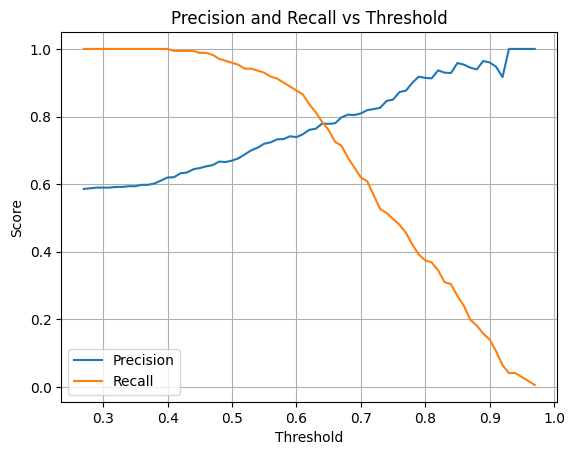

Precision ≈ Recall at threshold: 0.640


In [237]:
# Define thresholds from 0.0 to 1.0 (step = 0.01)
thresholds = np.arange(0.0, 1.01, 0.01)

precisions, recalls, valid_t = [], [], []

for t in thresholds:
    y_pred = (y_val_proba >= t)

    # Skip degenerate thresholds (all negatives or all positives)
    if y_pred.sum() == 0 or y_pred.sum() == len(y_pred):
        continue

    # zero_division=0 is optional but keeps things quiet at edges
    p = precision_score(y_val, y_pred, zero_division=0)
    r = recall_score(y_val, y_pred, zero_division=0)

    precisions.append(p)
    recalls.append(r)
    valid_t.append(t)

# ---- Plot (use valid_t, not thresholds) ----
plt.plot(valid_t, precisions, label='Precision')
plt.plot(valid_t, recalls, label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Score'); plt.title('Precision and Recall vs Threshold')
plt.legend(); plt.grid(True); plt.show()

# ---- Intersection (precision ≈ recall) ----
diff = np.abs(np.array(precisions) - np.array(recalls))
t_star = valid_t[int(diff.argmin())]
print(f"Precision ≈ Recall at threshold: {t_star:.3f}")



Best threshold for F1: 0.570
Maximum F1 score: 0.812


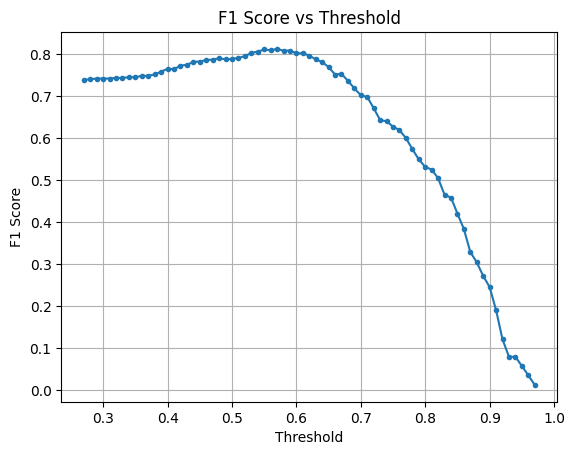

In [238]:
# Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

# Lists to store results
f1_scores = []
valid_t = []

# Loop through thresholds
for t in thresholds:
    y_pred = (y_val_proba >= t)
    
    # Skip degenerate thresholds (predicts all 0s or all 1s)
    if y_pred.sum() == 0 or y_pred.sum() == len(y_pred):
        continue
    
    # Compute precision & recall
    p = precision_score(y_val, y_pred, zero_division=0)
    r = recall_score(y_val, y_pred, zero_division=0)
    
    # Compute F1 score manually
    if (p + r) == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    
    f1_scores.append(f1)
    valid_t.append(t)

# Convert to arrays
valid_t = np.array(valid_t)
f1_scores = np.array(f1_scores)

# Find threshold with maximum F1
best_idx = np.argmax(f1_scores)
best_threshold = valid_t[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold for F1: {best_threshold:.3f}")
print(f"Maximum F1 score: {best_f1:.3f}")

# Plot the curve
plt.plot(valid_t, f1_scores, marker='.')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()



In [239]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
    # 1) Split into fold-train and fold-val
    df_tr = df_full_train.iloc[train_idx].reset_index(drop=True)
    df_va = df_full_train.iloc[val_idx].reset_index(drop=True)
    
    # 2) Separate target
    y_tr = df_tr['converted'].values
    y_va = df_va['converted'].values
    
    X_tr = df_tr.drop(columns=['converted'])
    X_va = df_va.drop(columns=['converted'])
    
    # 3) Build dicts for DictVectorizer
    train_dicts = X_tr[categorical + numerical].to_dict(orient='records')
    val_dicts   = X_va[categorical + numerical].to_dict(orient='records')
    
    # 4) Fit a fresh DictVectorizer on the fold-train only (avoid leakage)
    dv = DictVectorizer(sparse=False)
    X_tr_enc = dv.fit_transform(train_dicts)
    X_va_enc = dv.transform(val_dicts)
    
    # 5) Train a fresh Logistic Regression (course params)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_tr_enc, y_tr)
    
    # 6) Evaluate AUC on the fold-val
    y_va_proba = model.predict_proba(X_va_enc)[:, 1]
    auc = roc_auc_score(y_va, y_va_proba)
    scores.append(auc)
    
    print(f"Fold {fold_idx}: AUC = {auc:.3f}")

scores = np.array(scores)
print("AUC per fold:", np.round(scores, 3).tolist())
print("Mean AUC:", scores.mean().round(3))
print("Std of AUC:", scores.std(ddof=0).round(3))


Fold 1: AUC = 0.806
Fold 2: AUC = 0.871
Fold 3: AUC = 0.775
Fold 4: AUC = 0.802
Fold 5: AUC = 0.856
AUC per fold: [0.806, 0.871, 0.775, 0.802, 0.856]
Mean AUC: 0.822
Std of AUC: 0.036


In [240]:
C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_values:
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_tr = df_full_train.iloc[train_idx].reset_index(drop=True)
        df_va = df_full_train.iloc[val_idx].reset_index(drop=True)
        
        y_tr = df_tr['converted'].values
        y_va = df_va['converted'].values
        
        X_tr = df_tr.drop(columns=['converted'])
        X_va = df_va.drop(columns=['converted'])
        
        # DictVectorizer: fit only on train
        dv = DictVectorizer(sparse=False)
        X_tr_enc = dv.fit_transform(X_tr[categorical + numerical].to_dict(orient='records'))
        X_va_enc = dv.transform(X_va[categorical + numerical].to_dict(orient='records'))
        
        # Logistic Regression with current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_tr_enc, y_tr)
        
        y_va_proba = model.predict_proba(X_va_enc)[:, 1]
        auc = roc_auc_score(y_va, y_va_proba)
        scores.append(auc)
    
    # Compute mean and std
    scores = np.array(scores)
    mean_auc = np.round(scores.mean(), 3)
    std_auc  = np.round(scores.std(ddof=0), 3)
    
    print(f"C={C:<10} -> mean AUC: {mean_auc:.3f} | std: {std_auc:.3f}")


C=1e-06      -> mean AUC: 0.560 | std: 0.024
C=0.001      -> mean AUC: 0.867 | std: 0.029
C=1          -> mean AUC: 0.822 | std: 0.036
